## Deep Learning Portfolio Optimization

## Library imports & Data Loading

In [100]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")
print("Libraries imported successfully.")

tickers = ['SPY', 'QQQ', 'IWM', 'RSP', 'MSFT', 'AAPL', 'TSLA', 'NVDA']
start_date = '2010-01-01'
end_date = '2025-01-01'
print(f"Tickers defined: {tickers}")
print(f"Start date: {start_date}, End date: {end_date}")

data = yf.download(tickers, start=start_date, end=end_date)
print("Data downloaded successfully.")

close_prices = data['Close']
daily_simple_returns = close_prices.pct_change()
daily_simple_returns.columns = [f'{col}_simple_returns' for col in daily_simple_returns.columns]
print("Daily simple returns calculated successfully.")

weekly_prices = data['Close'].resample('W').last()
print("Daily prices resampled to weekly frequency successfully.")

weekly_log_returns = np.log(weekly_prices / weekly_prices.shift(1))
weekly_log_returns.columns = [f'{col}_returns' for col in weekly_log_returns.columns]
print("Weekly log-returns calculated successfully.")

daily_simple_returns = daily_simple_returns.iloc[1:]
print("Daily simple returns DataFrame aligned by dropping the first row.")

short_ma_daily = pd.DataFrame()
long_ma_daily = pd.DataFrame()

for ticker in tickers:
    short_ma_daily[f'{ticker}_short_ma'] = close_prices[ticker].rolling(window=5).mean()
    long_ma_daily[f'{ticker}_long_ma'] = close_prices[ticker].rolling(window=20).mean()

print("Daily short and long moving averages calculated successfully.")

volatility_daily = pd.DataFrame()

for ticker in tickers:
    volatility_daily[f'{ticker}_volatility'] = daily_simple_returns[f'{ticker}_simple_returns'].rolling(window=20).std()

print("Daily volatilities calculated successfully.")

short_ma_daily_aligned = short_ma_daily.dropna()
long_ma_daily_aligned = long_ma_daily.dropna()
volatility_daily_aligned = volatility_daily.dropna()

print("Daily moving averages and volatilities DataFrames aligned by dropping NaN values.")

weekly_short_ma_features = short_ma_daily_aligned.resample('W').last()
weekly_long_ma_features = long_ma_daily_aligned.resample('W').last()
weekly_volatility_features = volatility_daily_aligned.resample('W').last()

print("Daily features resampled to weekly frequency successfully.")

combined_weekly_features = pd.concat([
    weekly_log_returns,
    weekly_short_ma_features,
    weekly_long_ma_features,
    weekly_volatility_features
], axis=1)

print("Weekly features concatenated successfully.")

combined_weekly_features = combined_weekly_features.dropna()
print("NaN values removed from combined_weekly_features.")

[                       0%                       ]

Libraries imported successfully.
Tickers defined: ['SPY', 'QQQ', 'IWM', 'RSP', 'MSFT', 'AAPL', 'TSLA', 'NVDA']
Start date: 2010-01-01, End date: 2025-01-01


[*********************100%***********************]  8 of 8 completed


Data downloaded successfully.
Daily simple returns calculated successfully.
Daily prices resampled to weekly frequency successfully.
Weekly log-returns calculated successfully.
Daily simple returns DataFrame aligned by dropping the first row.
Daily short and long moving averages calculated successfully.
Daily volatilities calculated successfully.
Daily moving averages and volatilities DataFrames aligned by dropping NaN values.
Daily features resampled to weekly frequency successfully.
Weekly features concatenated successfully.
NaN values removed from combined_weekly_features.


## Feature Engineering & Data Preprocessing

In [101]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

def make_sequences(dataframe, sequence_length, feature_cols, target_cols):
    X, y = [], []
    features = dataframe[feature_cols].values
    targets = dataframe[target_cols].values
    for i in range(len(dataframe) - sequence_length):
        X.append(features[i : i + sequence_length])
        y.append(targets[i + sequence_length])
    return np.array(X), np.array(y)

# 2. Split the combined_weekly_features DataFrame into training, validation, and test sets.
total_len = len(combined_weekly_features)
train_size = int(0.7 * total_len)
val_size = int(0.15 * total_len)
test_size = total_len - train_size - val_size

train_df = combined_weekly_features.iloc[:train_size]
val_df = combined_weekly_features.iloc[train_size : train_size + val_size]
test_df = combined_weekly_features.iloc[train_size + val_size :]

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

# 3. Identify feature columns and target columns.
feature_cols = [col for col in combined_weekly_features.columns if not col.endswith('_returns')]
target_cols = [col for col in combined_weekly_features.columns if col.endswith('_returns')]

# 4. Initialize two StandardScaler objects: feature_scaler for features and target_scaler for target returns.
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# 5. Fit feature_scaler and target_scaler on the training data and then transform the training data.
X_train_scaled = feature_scaler.fit_transform(train_df[feature_cols])
y_train_scaled = target_scaler.fit_transform(train_df[target_cols])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=train_df.index)
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=target_cols, index=train_df.index)

# 6. Transform the validation and test data using the *fitted* feature_scaler and target_scaler.
X_val_scaled = feature_scaler.transform(val_df[feature_cols])
y_val_scaled = target_scaler.transform(val_df[target_cols])
X_test_scaled = feature_scaler.transform(test_df[feature_cols])
y_test_scaled = target_scaler.transform(test_df[target_cols])

X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=feature_cols, index=val_df.index)
y_val_scaled_df = pd.DataFrame(y_val_scaled, columns=target_cols, index=val_df.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=test_df.index)
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=target_cols, index=test_df.index)

print("Data scaled successfully.")

# 7. Concatenate the scaled feature and target DataFrames for each split for sequence creation
train_combined_scaled_df = pd.concat([X_train_scaled_df, y_train_scaled_df], axis=1)
val_combined_scaled_df = pd.concat([X_val_scaled_df, y_val_scaled_df], axis=1)
test_combined_scaled_df = pd.concat([X_test_scaled_df, y_test_scaled_df], axis=1)

# 8. Apply the make_sequences function to create sequential data.
sequence_length = 12 # Define sequence length

X_train_seq, y_train_seq = make_sequences(train_combined_scaled_df, sequence_length, feature_cols, target_cols)
X_val_seq, y_val_seq = make_sequences(val_combined_scaled_df, sequence_length, feature_cols, target_cols)
X_test_seq, y_test_seq = make_sequences(test_combined_scaled_df, sequence_length, feature_cols, target_cols)

print(f"Sequential data created with sequence length: {sequence_length}.")

# 9. Convert the sequential NumPy arrays into PyTorch tensors.
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

print("Sequential data converted to PyTorch tensors.")

# 10. Create TensorDataset objects.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

print("TensorDatasets created.")

# 11. Create DataLoader objects.
batch_size = 32 # Define batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch size: {batch_size}.")


Train size: 527, Validation size: 113, Test size: 114
Data scaled successfully.
Sequential data created with sequence length: 12.
Sequential data converted to PyTorch tensors.
TensorDatasets created.
DataLoaders created with batch size: 32.


## Transformer Model Definitions


In [102]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """Injects some information about the relative or absolute position of the tokens in the sequence."""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """Adds positional encoding to the input tensor."""
        # x is expected to be of shape (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0), :]
        return x

class PortfolioTransformer(nn.Module):
    """Transformer model for portfolio allocation."""
    def __init__(self, input_dim, d_model, n_heads, num_layers, dim_feedforward, output_dim, dropout=0.1, max_len=5000):
        super(PortfolioTransformer, self).__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model

        # 3a. Linear layer to project input features to d_model
        self.input_linear = nn.Linear(input_dim, d_model)

        # 3b. Positional Encoding layer
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # 3c. Transformer Encoder Layer
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False # Input is (seq_len, batch_size, feature_dim)
        )

        # 3d. Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        # 3e. Final linear layer to map Transformer's output to target assets
        self.output_linear = nn.Linear(d_model, output_dim)

        # 3f. Softmax activation for normalized portfolio weights
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """Forward pass for the PortfolioTransformer model."""
        # x shape: (batch_size, sequence_length, input_dim)
        # Transformer expects (sequence_length, batch_size, feature_dim)
        x = x.permute(1, 0, 2) # (sequence_length, batch_size, input_dim)

        # 4a. Pass input through initial linear projection
        x = self.input_linear(x) * math.sqrt(self.d_model)

        # 4b. Add positional encodings
        x = self.pos_encoder(x)

        # 4c. Pass through TransformerEncoder
        output = self.transformer_encoder(x)

        # 4d. Apply the final linear layer (taking the last time step's output)
        # output shape is (sequence_length, batch_size, d_model)
        # We take the output of the last time step for prediction
        output = self.output_linear(output[-1, :, :]) # (batch_size, output_dim)

        # 4e. Apply softmax for normalized portfolio weights
        weights = self.softmax(output)

        return weights

print("PositionalEncoding and PortfolioTransformer classes defined successfully.")

PositionalEncoding and PortfolioTransformer classes defined successfully.


## LSTM Model Definitions

In [103]:
import torch.nn as nn
import torch

class PortfolioLSTM(nn.Module):
    """LSTM model for portfolio allocation."""
    def __init__(self, input_size, hidden_size, num_layers, output_dim, dropout=0.1):
        super(PortfolioLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 2a. LSTM layer
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True, # Input and output tensors are provided as (batch, seq, feature)
            dropout=dropout
        )

        # 2b. Final linear layer to map LSTM's output to target assets
        self.fc = nn.Linear(hidden_size, output_dim)

        # 2c. Softmax activation for normalized portfolio weights
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """Forward pass for the PortfolioLSTM model."""
        # x shape: (batch_size, sequence_length, input_size)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 3a. Pass input through LSTM layer
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # hn: tensor of shape (num_layers, batch_size, hidden_size)
        # cn: tensor of shape (num_layers, batch_size, hidden_size)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # 3b. Take the output from the last time step of the LSTM sequence
        # For batch_first=True, the last time step is out[:, -1, :]
        last_step_output = out[:, -1, :]

        # 3c. Pass this last-step output through the final linear layer
        linear_output = self.fc(last_step_output)

        # 3d. Apply softmax for normalized portfolio weights
        weights = self.softmax(linear_output)

        return weights

print("PortfolioLSTM class defined successfully.")

PortfolioLSTM class defined successfully.


## Define Model Evaluation Function & Loss Function (Sharpe Ratio)

In [104]:
import torch
import numpy as np

def evaluate_model(model, data_loader, y_scaler):
    # 2. Set the model to evaluation mode and disable gradient calculation.
    model.eval()
    all_weights = []
    all_returns = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            # 6. Move X_batch and y_batch to the appropriate device (CPU or GPU).
            device = next(model.parameters()).device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # 7. Pass X_batch through the model to obtain predicted_weights.
            predicted_weights = model(X_batch)

            # 8. Convert y_batch to a NumPy array and then denormalize it.
            y_batch_np = y_batch.cpu().numpy()
            denormalized_returns_batch = y_scaler.inverse_transform(y_batch_np)

            # 9. Append the predicted_weights and the denormalized_returns_batch to their respective lists.
            all_weights.append(predicted_weights.cpu().numpy())
            all_returns.append(denormalized_returns_batch)

    # 10. Concatenate all collected predicted_weights and all_returns arrays horizontally.
    all_weights = np.concatenate(all_weights, axis=0)
    all_returns = np.concatenate(all_returns, axis=0)

    # 11. Calculate portfolio_returns
    portfolio_returns = np.sum(all_weights * all_returns, axis=1)

    # 12. Calculate the cumulative_return
    cumulative_return = np.prod(1 + portfolio_returns) - 1

    # 13. Calculate the volatility
    volatility = np.std(portfolio_returns)

    # 14. Calculate the sharpe_ratio with numerical stability
    sharpe_ratio = np.mean(portfolio_returns) / (volatility + 1e-6)

    # 15. Return the calculated cumulative_return, volatility, and sharpe_ratio.
    return cumulative_return, volatility, sharpe_ratio

print("Model evaluation function `evaluate_model` defined successfully.")

Model evaluation function `evaluate_model` defined successfully.


## Execute Reduced Hyperparameter Search (Transformer with Sharpe Ratio Loss)

In [105]:
import torch.nn as nn
import torch
import numpy as np

def sharpe_ratio_loss(weights, returns):
    # Ensure returns are 2D for batch processing if they come as 1D
    if returns.dim() == 1:
        returns = returns.unsqueeze(0) # Make it (1, num_assets)

    # Ensure weights are 2D for batch processing if they come as 1D
    if weights.dim() == 1:
        weights = weights.unsqueeze(0) # Make it (1, num_assets)

    # Calculate portfolio returns: (batch_size, num_assets) * (batch_size, num_assets) -> (batch_size,)
    portfolio_returns = torch.sum(weights * returns, dim=1)

    # Calculate the mean of portfolio returns
    mean_portfolio_return = torch.mean(portfolio_returns)

    # Calculate the standard deviation of portfolio returns with numerical stability
    std_portfolio_return = torch.std(portfolio_returns) + 1e-6

    # Calculate Sharpe Ratio
    sharpe_ratio = mean_portfolio_return / std_portfolio_return

    # Return the negative Sharpe Ratio for minimization
    return -sharpe_ratio

def evaluate_model(model, data_loader, y_scaler):
    model.eval() # Set the model to evaluation mode
    all_weights = []
    all_returns = []

    with torch.no_grad(): # Disable gradient calculation for inference
        for X_batch, y_batch in data_loader:
            # Move data to the same device as the model
            device = next(model.parameters()).device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predicted_weights = model(X_batch)

            y_batch_np = y_batch.cpu().numpy()
            denormalized_returns_batch = y_scaler.inverse_transform(y_batch_np)

            all_weights.append(predicted_weights.cpu().numpy())
            all_returns.append(denormalized_returns_batch)

    # Concatenate all predicted weights and actual denormalized returns
    all_weights = np.concatenate(all_weights, axis=0)
    all_returns = np.concatenate(all_returns, axis=0)

    # Calculate portfolio returns (dot product of weights and returns)
    portfolio_returns = np.sum(all_weights * all_returns, axis=1)

    # Calculate the cumulative returns
    # Add 1 to portfolio_returns before cumulative product
    cumulative_return = np.prod(1 + portfolio_returns) - 1

    # Calculate the volatility
    volatility = np.std(portfolio_returns)

    # Calculate the Sharpe Ratio with numerical stability
    sharpe_ratio = np.mean(portfolio_returns) / (volatility + 1e-6)

    # Return portfolio_returns along with the other metrics
    return cumulative_return, volatility, sharpe_ratio, portfolio_returns

import itertools
import torch.optim as optim
import copy # For deep copying model states
import torch # Ensure torch is imported

# 1. Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Define fixed hyperparameters for the Transformer model
fixed_transformer_hps = {
    'd_model': 64,
    'n_heads': 4,
    'num_layers': 2,
    'dim_feedforward': 128,
    'dropout': 0.1
}

# 3. Define tuneable hyperparameters
hyperparams_reduced = {
    'lr': [0.0001, 0.001, 0.01],
    'weight_decay': [1e-5, 1e-4, 1e-3],
    'patience': [5, 7, 10]
}

# 4. Generate all possible combinations of the tuneable hyperparameters.
hyparam_names_reduced = list(hyperparams_reduced.keys())
hyparam_combinations_reduced = list(itertools.product(*hyperparams_reduced.values()))

# Get input and output dimensions from the prepared tensors
# These should be available from the consolidated data preprocessing step.
# Assuming X_train_tensor and y_train_tensor are defined globally.
input_dim = X_train_tensor.shape[-1]
output_dim = y_train_tensor.shape[-1]

# 5. Initialize an empty list results_sharpe to store the results
results_sharpe = []
# Variables to track the best validation Sharpe Ratio for overall best config
best_test_sharpe_overall = -float('inf')
best_config_overall = None

print(f"Total hyperparameter combinations to test: {len(hyparam_combinations_reduced)}")
print(f"Input Dimension: {input_dim}, Output Dimension: {output_dim}")


num_epochs = 50 # Define a fixed number of epochs for training

# 6. Loop through each hyperparameter combination:
for i, combo in enumerate(hyparam_combinations_reduced):
    current_hps = dict(zip(hyparam_names_reduced, combo))
    print(f"\n--- Testing Combination {i+1}/{len(hyparam_combinations_reduced)}: {current_hps} ---")

    # Initialize the PortfolioTransformer model
    model = PortfolioTransformer(
        input_dim=input_dim,
        d_model=fixed_transformer_hps['d_model'],
        n_heads=fixed_transformer_hps['n_heads'],
        num_layers=fixed_transformer_hps['num_layers'],
        dim_feedforward=fixed_transformer_hps['dim_feedforward'],
        output_dim=output_dim,
        dropout=fixed_transformer_hps['dropout']
    ).to(device)

    # Initialize the Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=current_hps['lr'], weight_decay=current_hps['weight_decay'])

    # Initialize best_val_sharpe for the current run and patience_counter
    best_val_sharpe = -float('inf')
    patience_counter = 0
    best_model_state = None # To save the best model state during validation

    # Training loop for a fixed number of epochs
    for epoch in range(num_epochs):
        model.train() # Set the model to training mode
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad() # Zero the gradients

            predicted_weights = model(X_batch) # Get model predictions (weights)

            loss = sharpe_ratio_loss(predicted_weights, y_batch) # Calculate the sharpe_ratio_loss
            loss.backward() # Perform backpropagation
            optimizer.step() # Update model weights

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader) # Calculate the average training loss for the epoch

        # Evaluate the model on the validation set
        _, _, val_sharpe, _ = evaluate_model(model, val_loader, target_scaler)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Sharpe: {val_sharpe:.4f}")

        # Implement early stopping
        if val_sharpe > best_val_sharpe:
            best_val_sharpe = val_sharpe
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict()) # Save the best model state
        else:
            patience_counter += 1
            if patience_counter >= current_hps['patience']:
                print(f"Early stopping triggered after {epoch+1} epochs due to no improvement for {current_hps['patience']} epochs.")
                break

    # Load the best model state before testing
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Evaluate the final model on the test set AND capture portfolio returns
    # The evaluate_model function already returns test_portfolio_returns
    test_cumulative_return, test_volatility, test_sharpe_ratio, test_portfolio_returns = evaluate_model(model, test_loader, target_scaler)

    # Store the results, including the portfolio_returns array
    results_sharpe.append({
        'hyperparams': current_hps,
        'cumulative_return': test_cumulative_return,
        'volatility': test_volatility,
        'sharpe_ratio': test_sharpe_ratio,
        'portfolio_returns': test_portfolio_returns # Store the actual portfolio returns for plotting
    })

    # Update overall best configuration
    # Deep copy the best result dictionary to avoid issues with mutable objects
    if test_sharpe_ratio > best_test_sharpe_overall:
        best_test_sharpe_overall = test_sharpe_ratio
        best_config_overall = copy.deepcopy(results_sharpe[-1]) # Store the last appended result (which includes portfolio_returns)

# 7. Convert results_sharpe into a pandas DataFrame
results_sharpe_df = pd.DataFrame(results_sharpe)

# 8. Print the best_config_overall
print("\n--- Best Transformer Model Configuration (Sharpe Ratio Loss) ---")
print(best_config_overall)


Using device: cpu
Total hyperparameter combinations to test: 27
Input Dimension: 24, Output Dimension: 8

--- Testing Combination 1/27: {'lr': 0.0001, 'weight_decay': 1e-05, 'patience': 5} ---
Epoch 1/50, Train Loss: 0.0152, Val Sharpe: 0.0328
Epoch 2/50, Train Loss: -0.0970, Val Sharpe: 0.0333
Epoch 3/50, Train Loss: -0.0066, Val Sharpe: 0.0334
Epoch 4/50, Train Loss: 0.0676, Val Sharpe: 0.0344
Epoch 5/50, Train Loss: -0.0690, Val Sharpe: 0.0361
Epoch 6/50, Train Loss: -0.0288, Val Sharpe: 0.0368
Epoch 7/50, Train Loss: -0.0622, Val Sharpe: 0.0375
Epoch 8/50, Train Loss: -0.0917, Val Sharpe: 0.0385
Epoch 9/50, Train Loss: -0.0167, Val Sharpe: 0.0387
Epoch 10/50, Train Loss: -0.1101, Val Sharpe: 0.0387
Epoch 11/50, Train Loss: -0.0349, Val Sharpe: 0.0381
Epoch 12/50, Train Loss: -0.0424, Val Sharpe: 0.0377
Epoch 13/50, Train Loss: -0.0992, Val Sharpe: 0.0376
Epoch 14/50, Train Loss: 0.0091, Val Sharpe: 0.0373
Epoch 15/50, Train Loss: 1.0612, Val Sharpe: 0.0368
Early stopping triggered 

## Execute Reduced Hyperparameter Search (LSTM with Sharpe Ratio Loss)

In [106]:
import itertools
import torch.optim as optim
import copy # For deep copying model states
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

# --- PortfolioLSTM class definition (re-included for self-containment) ---
class PortfolioLSTM(nn.Module):
    """LSTM model for portfolio allocation."""
    def __init__(self, input_size, hidden_size, num_layers, output_dim, dropout=0.1):
        super(PortfolioLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 2a. LSTM layer
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True, # Input and output tensors are provided as (batch, seq, feature)
            dropout=dropout
        )

        # 2b. Final linear layer to map LSTM's output to target assets
        self.fc = nn.Linear(hidden_size, output_dim)

        # 2c. Softmax activation for normalized portfolio weights
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """Forward pass for the PortfolioLSTM model."""
        # x shape: (batch_size, sequence_length, input_size)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 3a. Pass input through LSTM layer
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # hn: tensor of shape (num_layers, batch_size, hidden_size)
        # cn: tensor of shape (num_layers, batch_size, hidden_size)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # 3b. Take the output from the last time step of the LSTM sequence
        # For batch_first=True, the last time step is out[:, -1, :]
        last_step_output = out[:, -1, :]

        # 3c. Pass this last-step output through the final linear layer
        linear_output = self.fc(last_step_output)

        # 3d. Apply softmax for normalized portfolio weights
        weights = self.softmax(linear_output)

        return weights
# --- End PortfolioLSTM class definition ---

# sharpe_ratio_loss function definition
def sharpe_ratio_loss(weights, returns):
    # Ensure returns are 2D for batch processing if they come as 1D
    if returns.dim() == 1:
        returns = returns.unsqueeze(0) # Make it (1, num_assets)

    # Ensure weights are 2D for batch processing if they come as 1D
    if weights.dim() == 1:
        weights = weights.unsqueeze(0) # Make it (1, num_assets)

    # Calculate portfolio returns: (batch_size, num_assets) * (batch_size, num_assets) -> (batch_size,)
    portfolio_returns = torch.sum(weights * returns, dim=1)

    # Calculate the mean of portfolio returns
    mean_portfolio_return = torch.mean(portfolio_returns)

    # Calculate the standard deviation of portfolio returns with numerical stability
    std_portfolio_return = torch.std(portfolio_returns) + 1e-6

    # Calculate Sharpe Ratio
    sharpe_ratio = mean_portfolio_return / std_portfolio_return

    # Return the negative Sharpe Ratio for minimization
    return -sharpe_ratio

# evaluate_model function definition
def evaluate_model(model, data_loader, y_scaler):
    # Set the model to evaluation mode and disable gradient calculation.
    model.eval()
    all_weights = []
    all_returns = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            # Move data to the same device as the model
            device = next(model.parameters()).device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Pass the input features through the model to get predicted weights.
            predicted_weights = model(X_batch)

            # Convert y_batch (scaled returns) to NumPy for inverse_transform
            y_batch_np = y_batch.cpu().numpy()

            # Denormalize the actual target returns
            denormalized_returns_batch = y_scaler.inverse_transform(y_batch_np)

            # Append to lists
            all_weights.append(predicted_weights.cpu().numpy())
            all_returns.append(denormalized_returns_batch)

    # Concatenate all predicted weights and denormalized actual returns
    all_weights = np.concatenate(all_weights, axis=0)
    all_returns = np.concatenate(all_returns, axis=0)

    # Calculate portfolio returns (dot product of weights and returns)
    portfolio_returns = np.sum(all_weights * all_returns, axis=1)

    # Calculate the cumulative returns
    # Add 1 to portfolio_returns before cumulative product
    cumulative_return = np.prod(1 + portfolio_returns) - 1

    # Calculate the volatility
    volatility = np.std(portfolio_returns)

    # Calculate the Sharpe Ratio with numerical stability
    sharpe_ratio = np.mean(portfolio_returns) / (volatility + 1e-6)

    # Return the cumulative_return, volatility, and sharpe_ratio.
    return cumulative_return, volatility, sharpe_ratio, portfolio_returns


# 1. Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Define fixed hyperparameters for the LSTM model
fixed_lstm_hps = {
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.1
}

# 3. Define tuneable hyperparameters (same as Transformer)
hyperparams_lstm_reduced = {
    'lr': [0.0001, 0.001, 0.01],
    'weight_decay': [1e-5, 1e-4, 1e-3],
    'patience': [5, 7, 10]
}

# 4. Generate all possible combinations of the tuneable hyperparameters.
hyparam_names_lstm_reduced = list(hyperparams_lstm_reduced.keys())
hyparam_combinations_lstm_reduced = list(itertools.product(*hyperparams_lstm_reduced.values()))

# Get input and output dimensions from the prepared tensors (already defined globally)
# input_dim = X_train_tensor.shape[-1]
# output_dim = y_train_tensor.shape[-1]

# 5. Initialize an empty list results_sharpe_lstm to store the results
results_sharpe_lstm = []
# Variables to track the best validation Sharpe Ratio for overall best config
best_test_sharpe_overall_lstm = -float('inf')
best_config_overall_lstm = None

print(f"Total LSTM hyperparameter combinations to test: {len(hyparam_combinations_lstm_reduced)}")
print(f"Input Dimension: {input_dim}, Output Dimension: {output_dim}")

# 6. Define a fixed number of epochs for training
num_epochs = 50 # Re-using the same num_epochs as Transformer

# Loop through each hyperparameter combination:
for i, combo in enumerate(hyparam_combinations_lstm_reduced):
    current_hps_lstm = dict(zip(hyparam_names_lstm_reduced, combo))
    print(f"\n--- Testing LSTM Combination {i+1}/{len(hyparam_combinations_lstm_reduced)}: {current_hps_lstm} ---")

    # Instantiate the PortfolioLSTM model
    model_lstm = PortfolioLSTM(
        input_size=input_dim,
        hidden_size=fixed_lstm_hps['hidden_size'],
        num_layers=fixed_lstm_hps['num_layers'],
        output_dim=output_dim,
        dropout=fixed_lstm_hps['dropout']
    ).to(device)

    # Initialize the Adam optimizer
    optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=current_hps_lstm['lr'], weight_decay=current_hps_lstm['weight_decay'])

    # Initialize best_val_sharpe_lstm for the current run and patience_counter_lstm
    best_val_sharpe_lstm = -float('inf')
    patience_counter_lstm = 0
    best_model_state_lstm = None # To save the best model state during validation

    # Training loop for a fixed number of epochs
    for epoch in range(num_epochs):
        model_lstm.train() # Set the model to training mode
        total_loss_lstm = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer_lstm.zero_grad() # Zero the gradients

            predicted_weights_lstm = model_lstm(X_batch) # Get model predictions (weights)

            loss_lstm = sharpe_ratio_loss(predicted_weights_lstm, y_batch) # Calculate the sharpe_ratio_loss
            loss_lstm.backward() # Perform backpropagation
            optimizer_lstm.step() # Update model weights

            total_loss_lstm += loss_lstm.item()

        avg_train_loss_lstm = total_loss_lstm / len(train_loader) # Calculate the average training loss for the epoch

        # Evaluate the model on the validation set
        _, _, val_sharpe_lstm, _ = evaluate_model(model_lstm, val_loader, target_scaler)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss_lstm:.4f}, Val Sharpe: {val_sharpe_lstm:.4f}")

        # Implement early stopping
        if val_sharpe_lstm > best_val_sharpe_lstm:
            best_val_sharpe_lstm = val_sharpe_lstm
            patience_counter_lstm = 0
            best_model_state_lstm = copy.deepcopy(model_lstm.state_dict()) # Save the best model state
        else:
            patience_counter_lstm += 1
            if patience_counter_lstm >= current_hps_lstm['patience']:
                print(f"Early stopping triggered after {epoch+1} epochs due to no improvement for {current_hps_lstm['patience']} epochs.")
                break

    # Load the best model state before testing
    if best_model_state_lstm:
        model_lstm.load_state_dict(best_model_state_lstm)

    # Evaluate the final model on the test set AND capture portfolio returns
    test_cumulative_return_lstm, test_volatility_lstm, test_sharpe_ratio_lstm, test_portfolio_returns_lstm = evaluate_model(model_lstm, test_loader, target_scaler)

    # Store the results
    results_sharpe_lstm.append({
        'hyperparams': current_hps_lstm,
        'cumulative_return': test_cumulative_return_lstm,
        'volatility': test_volatility_lstm,
        'sharpe_ratio': test_sharpe_ratio_lstm,
        'portfolio_returns': test_portfolio_returns_lstm # Store the actual portfolio returns for plotting
    })

    # Update overall best configuration
    if test_sharpe_ratio_lstm > best_test_sharpe_overall_lstm:
        best_test_sharpe_overall_lstm = test_sharpe_ratio_lstm
        best_config_overall_lstm = copy.deepcopy(results_sharpe_lstm[-1]) # Store the last appended result (which includes portfolio_returns)

# 7. Convert results_sharpe_lstm into a pandas DataFrame
results_sharpe_lstm_df = pd.DataFrame(results_sharpe_lstm)

# 8. Print the best_config_overall_lstm
print("\n--- Best LSTM Model Configuration (Sharpe Ratio Loss) ---")
print(best_config_overall_lstm)


Using device: cpu
Total LSTM hyperparameter combinations to test: 27
Input Dimension: 24, Output Dimension: 8

--- Testing LSTM Combination 1/27: {'lr': 0.0001, 'weight_decay': 1e-05, 'patience': 5} ---
Epoch 1/50, Train Loss: 0.0345, Val Sharpe: 0.0398
Epoch 2/50, Train Loss: 0.0057, Val Sharpe: 0.0398
Epoch 3/50, Train Loss: 0.0519, Val Sharpe: 0.0398
Epoch 4/50, Train Loss: -0.0187, Val Sharpe: 0.0399
Epoch 5/50, Train Loss: -0.0549, Val Sharpe: 0.0399
Epoch 6/50, Train Loss: 0.0513, Val Sharpe: 0.0398
Epoch 7/50, Train Loss: -0.0054, Val Sharpe: 0.0399
Epoch 8/50, Train Loss: 0.0146, Val Sharpe: 0.0399
Epoch 9/50, Train Loss: -0.0028, Val Sharpe: 0.0400
Epoch 10/50, Train Loss: 0.0280, Val Sharpe: 0.0399
Epoch 11/50, Train Loss: -0.0956, Val Sharpe: 0.0399
Epoch 12/50, Train Loss: 0.0100, Val Sharpe: 0.0399
Epoch 13/50, Train Loss: -0.0088, Val Sharpe: 0.0400
Epoch 14/50, Train Loss: -0.0243, Val Sharpe: 0.0400
Epoch 15/50, Train Loss: 0.0144, Val Sharpe: 0.0402
Epoch 16/50, Train 

## Feature Correlations


DataFrame 'features_only_df' created successfully.
Correlation matrix calculated successfully.


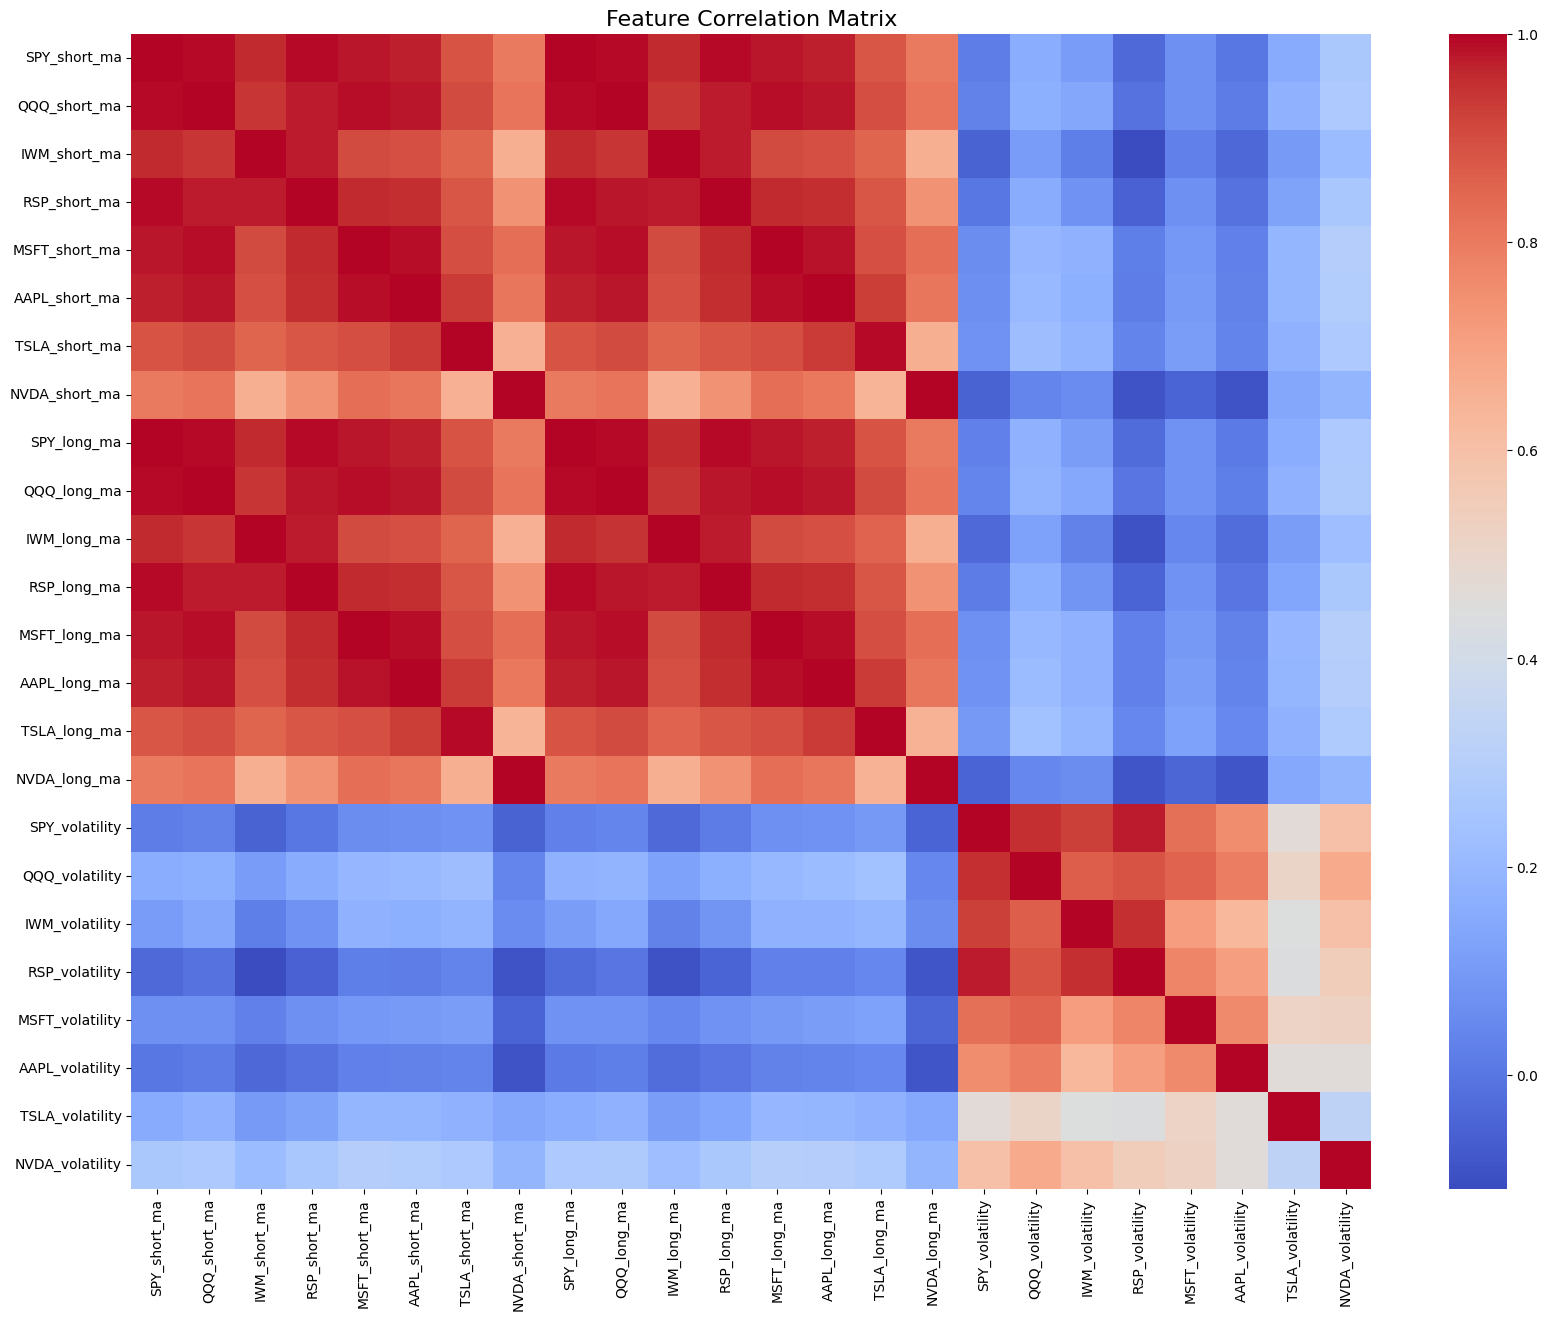

Feature correlation matrix heatmap displayed successfully.
Dictionary 'feature_importances' initialized.
Feature importances calculated for each asset successfully.
DataFrame 'feature_importances_df' created successfully.
Top 15 aggregated features:
TSLA_volatility    0.797298
AAPL_volatility    0.652182
NVDA_volatility    0.631022
MSFT_volatility    0.620087
IWM_volatility     0.584644
QQQ_volatility     0.556660
RSP_volatility     0.544005
SPY_volatility     0.537693
TSLA_long_ma       0.371963
TSLA_short_ma      0.300706
NVDA_short_ma      0.249905
IWM_long_ma        0.223535
IWM_short_ma       0.219706
MSFT_short_ma      0.189108
NVDA_long_ma       0.186971
dtype: float64


<Figure size 2000x1000 with 0 Axes>

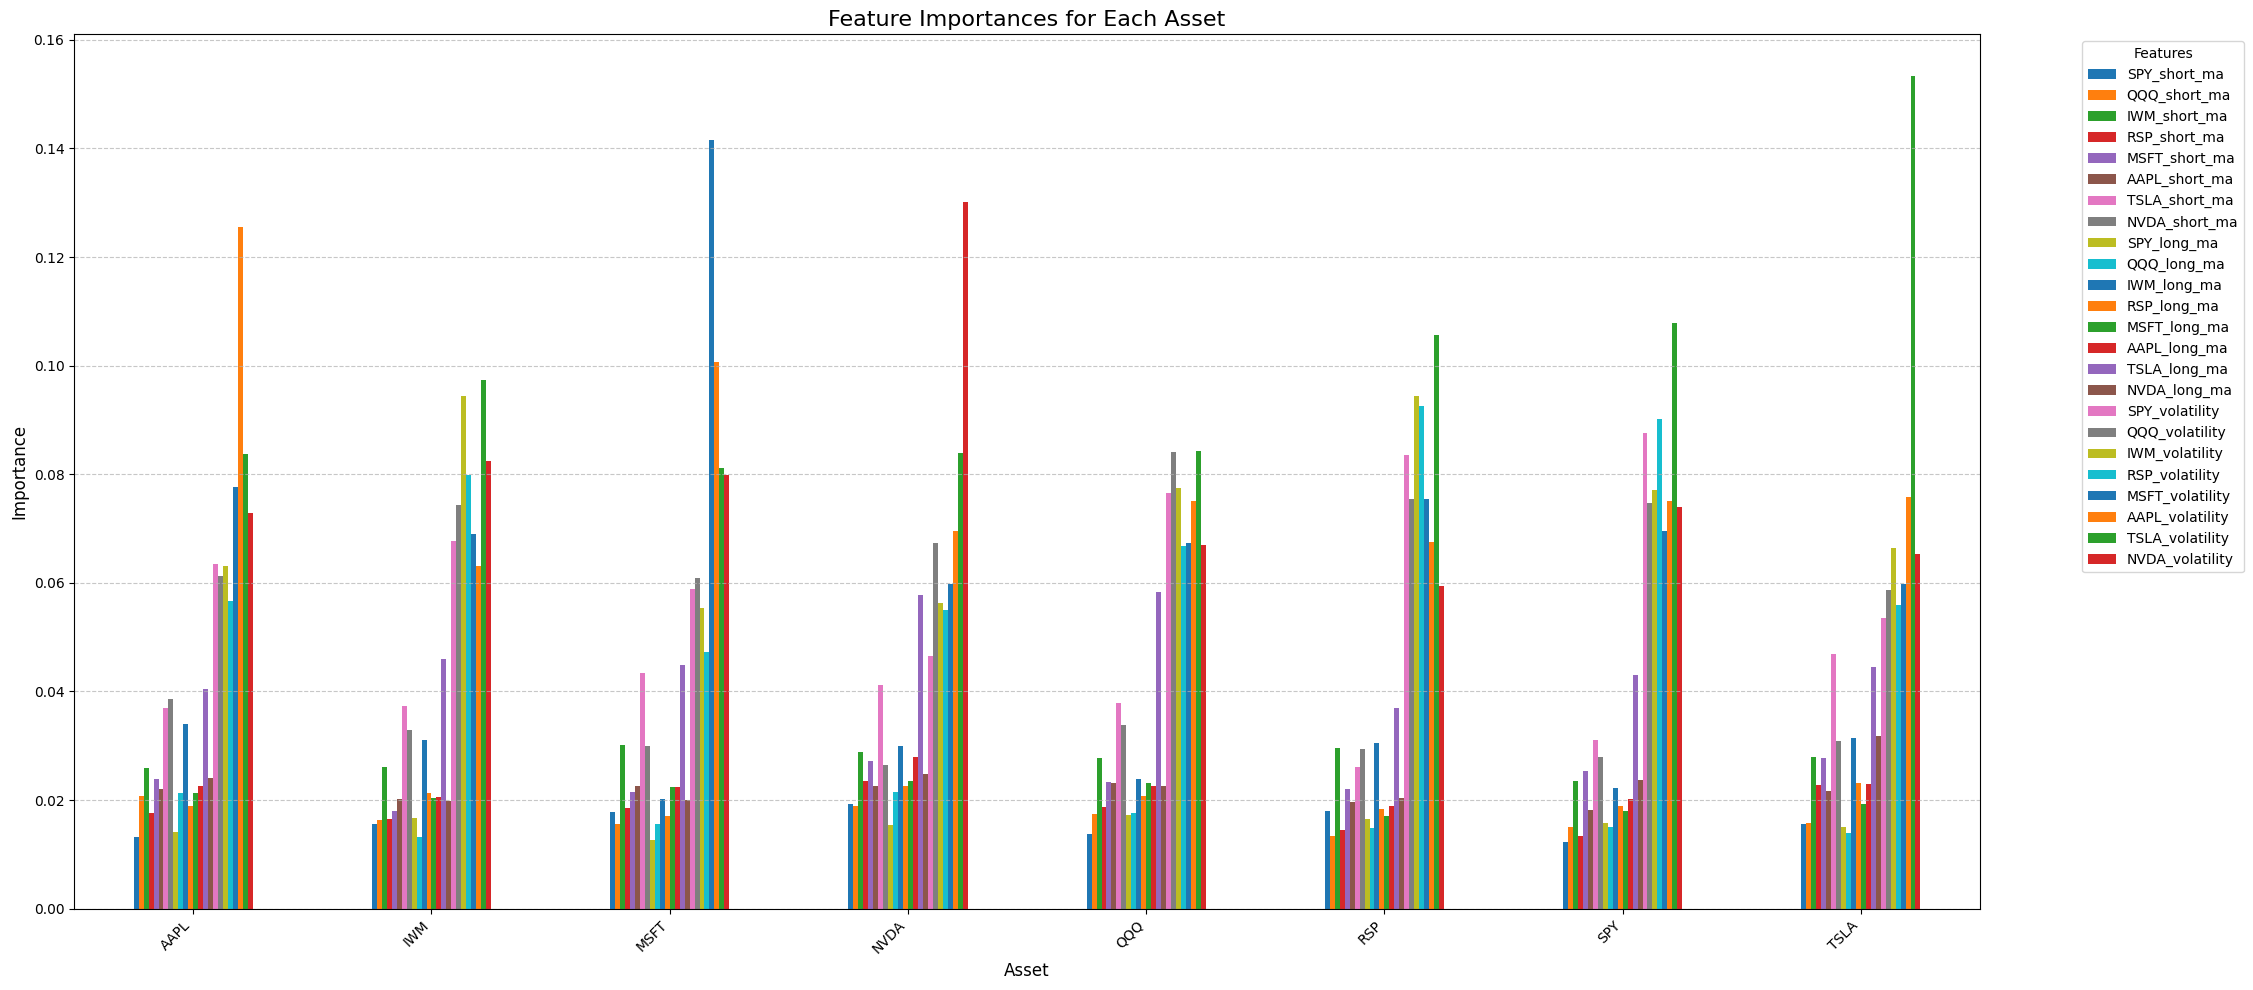

Feature importances bar plot for each asset displayed successfully.


In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1. Create a new DataFrame, features_only_df, by dropping all columns ending with '_returns' from `combined_weekly_features`.
# This ensures we are only correlating input features against each other.
features_only_df = combined_weekly_features.loc[:, ~combined_weekly_features.columns.str.endswith('_returns')]
print("DataFrame 'features_only_df' created successfully.")

# 2. Calculate the correlation matrix of features_only_df.
correlation_matrix = features_only_df.corr()
print("Correlation matrix calculated successfully.")

# 3. Create and display a heatmap of the correlation matrix for input features.
plt.figure(figsize=(20, 15)) # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f") # annot=False for large matrix
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
print("Feature correlation matrix heatmap displayed successfully.")

# 4. Prepare a dictionary named feature_importances to store feature importances for each asset.
feature_importances = {}
print("Dictionary 'feature_importances' initialized.")

# 5. Iterate through each target asset column (defined by `target_cols` from preprocessing) in `combined_weekly_features`.
# `target_cols` should be globally available from the preprocessing step.
for asset_return_col in target_cols:
    # Identify the current asset's return column as y_asset.
    y_asset = combined_weekly_features[asset_return_col]

    # Use features_only_df as the feature set X_asset for the RandomForestRegressor.
    # `X_asset` and `y_asset` should already be aligned by index and have no NaNs due to prior preprocessing steps.
    X_asset = features_only_df.copy()

    # Initialize and train a RandomForestRegressor model.
    # n_estimators=100 for robust importance, random_state for reproducibility, n_jobs=-1 for parallel processing.
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_asset, y_asset)

    # Extract feature importances and store them as a pandas Series, indexed by feature names.
    feature_importances[asset_return_col.replace('_returns', '')] = pd.Series(rf_model.feature_importances_, index=X_asset.columns)

print("Feature importances calculated for each asset successfully.")

# 6. Convert the feature_importances dictionary into a pandas DataFrame named feature_importances_df.
feature_importances_df = pd.DataFrame(feature_importances)
print("DataFrame 'feature_importances_df' created successfully.")

# 7. Aggregate feature importances across all assets by summing their importances.
aggregated_feature_importances = feature_importances_df.sum(axis=1).sort_values(ascending=False)
print("Top 15 aggregated features:")
print(aggregated_feature_importances.head(15))

# 8. Plot the feature importances for each asset using a bar plot for visual comparison.
plt.figure(figsize=(20, 10)) # Adjust figure size for better readability
# Transpose the DataFrame to have assets on the x-axis and features in the legend.
feature_importances_df.T.plot(kind='bar', figsize=(20, 10))
plt.title('Feature Importances for Each Asset', fontsize=16)
plt.xlabel('Asset', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot area
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Feature importances bar plot for each asset displayed successfully.")


## Summary & Visualizations

Model evaluation function `evaluate_model` redefined successfully to include portfolio returns.
Transformer and LSTM models portfolio returns loaded from best configurations.


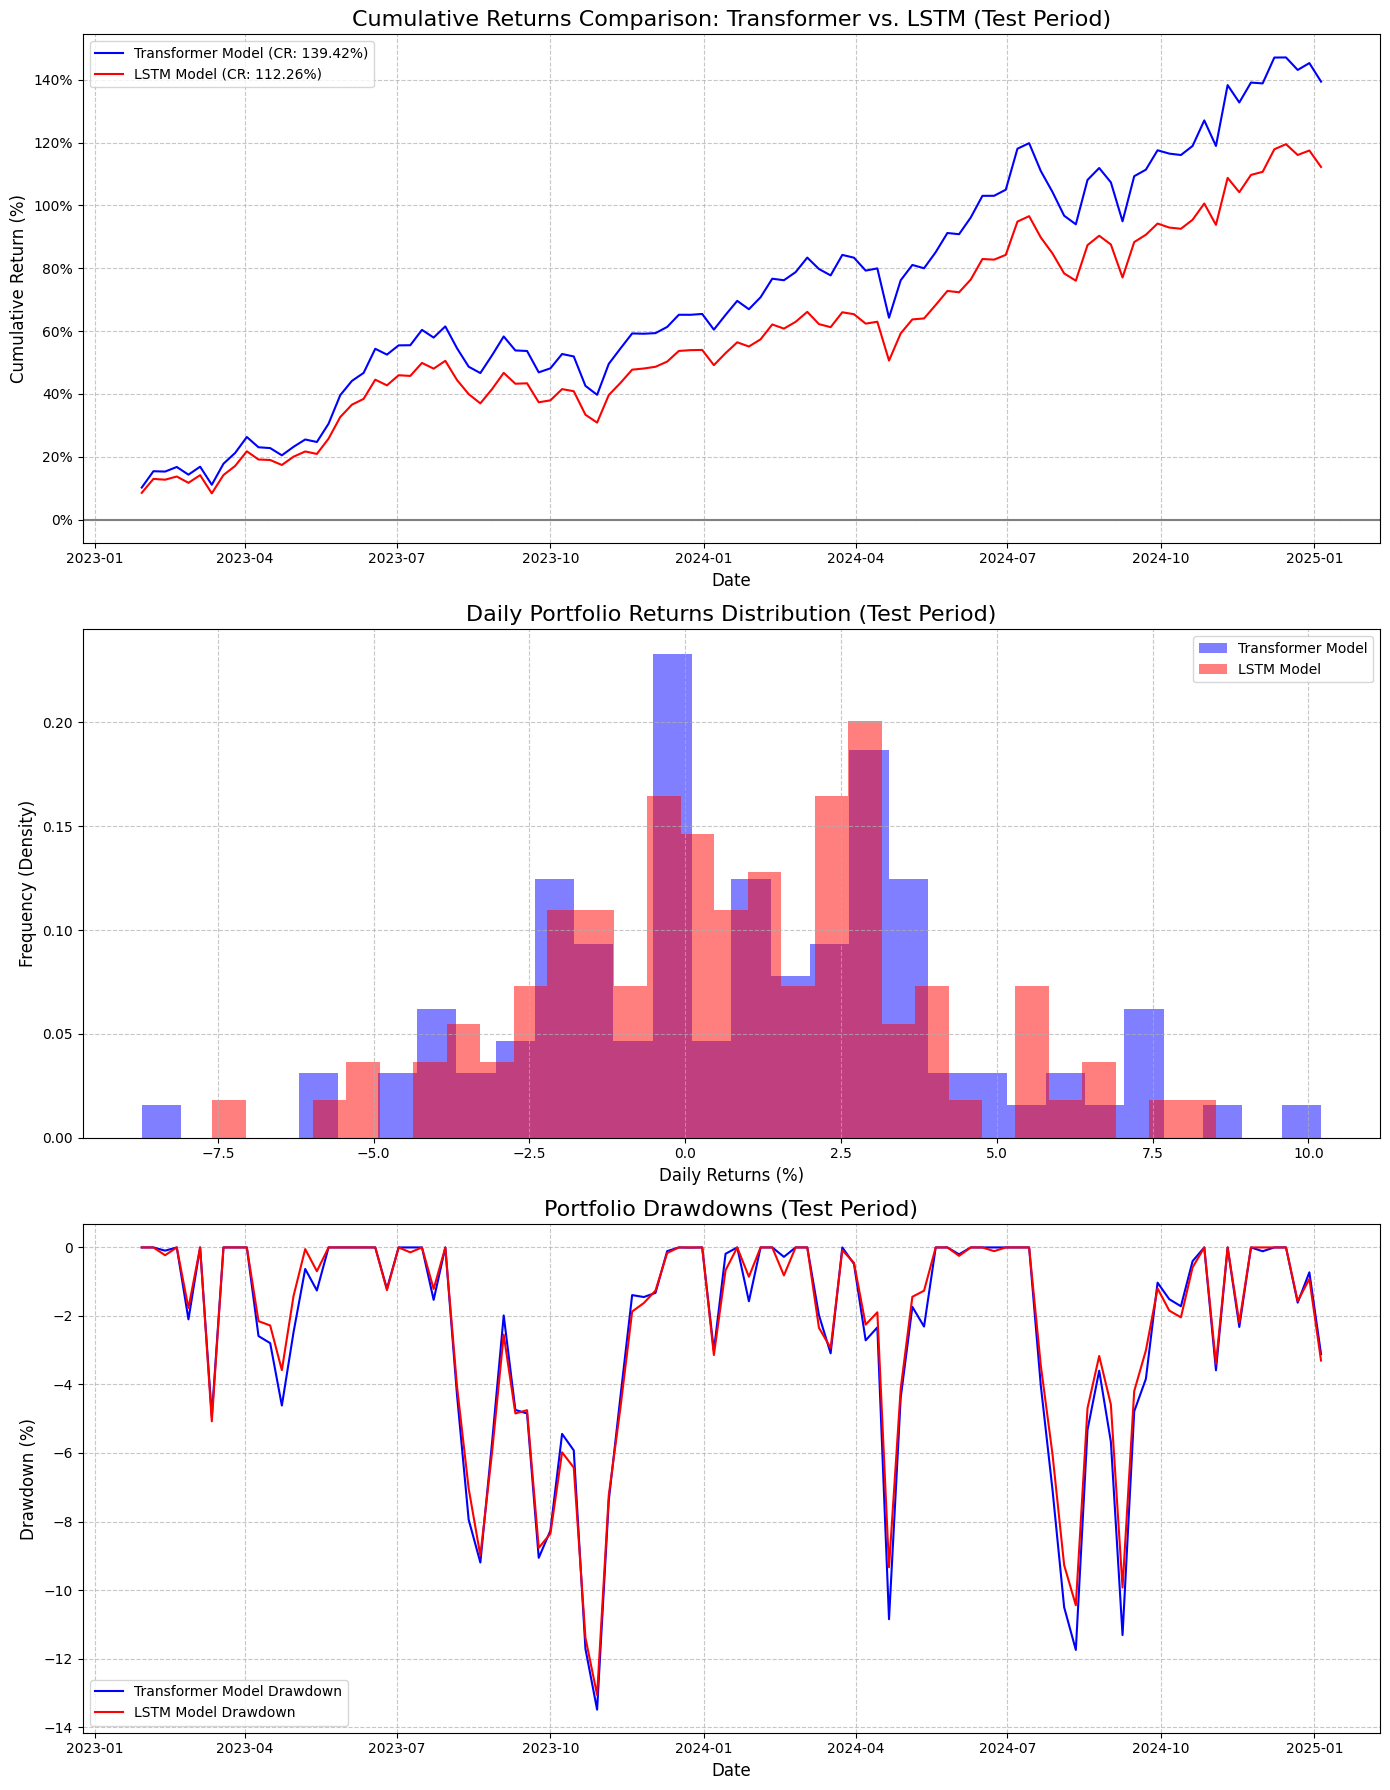


Cumulative returns, returns distribution, and drawdown plots generated successfully.


In [108]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Redefine the evaluate_model function to return portfolio_returns
def evaluate_model(model, data_loader, y_scaler):
    model.eval() # Set the model to evaluation mode
    all_weights = []
    all_returns = []

    with torch.no_grad(): # Disable gradient calculation for inference
        for X_batch, y_batch in data_loader:
            # Move data to the same device as the model
            device = next(model.parameters()).device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predicted_weights = model(X_batch)

            y_batch_np = y_batch.cpu().numpy()
            denormalized_returns_batch = y_scaler.inverse_transform(y_batch_np)

            all_weights.append(predicted_weights.cpu().numpy())
            all_returns.append(denormalized_returns_batch)

    # Concatenate all predicted weights and actual denormalized returns
    all_weights = np.concatenate(all_weights, axis=0)
    all_returns = np.concatenate(all_returns, axis=0)

    # Calculate portfolio returns (dot product of weights and returns)
    portfolio_returns = np.sum(all_weights * all_returns, axis=1)

    # Calculate the cumulative returns
    # Add 1 to portfolio_returns before cumulative product
    cumulative_return = np.prod(1 + portfolio_returns) - 1

    # Calculate the volatility
    volatility = np.std(portfolio_returns)

    # Calculate the Sharpe Ratio with numerical stability
    sharpe_ratio = np.mean(portfolio_returns) / (volatility + 1e-6)

    # Return portfolio_returns along with the other metrics
    return cumulative_return, volatility, sharpe_ratio, portfolio_returns

print("Model evaluation function `evaluate_model` redefined successfully to include portfolio returns.")


# Extract portfolio returns directly from the stored best configurations
transformer_test_portfolio_returns = best_config_overall['portfolio_returns']
lstm_test_portfolio_returns = best_config_overall_lstm['portfolio_returns']

print("Transformer and LSTM models portfolio returns loaded from best configurations.")


# --- Calculate and plot cumulative returns and drawdowns ---
if transformer_test_portfolio_returns is not None and lstm_test_portfolio_returns is not None:
    transformer_cumulative_returns = (1 + transformer_test_portfolio_returns).cumprod() - 1
    lstm_cumulative_returns = (1 + lstm_test_portfolio_returns).cumprod() - 1

    # Get the dates for the test set for plotting
    # `train_size`, `val_size`, `sequence_length` are assumed to be available from data preprocessing
    test_start_index = train_size + val_size + sequence_length

    # Assuming `combined_weekly_features` is still available from initial data loading/preprocessing.
    if 'combined_weekly_features' in globals():
        # Ensure the length of test_dates matches the length of cumulative_returns_series
        test_dates = combined_weekly_features.index[test_start_index: test_start_index + len(transformer_cumulative_returns)]
    else:
        print("Warning: combined_weekly_features not found. Plotting dates might be incorrect.")
        test_dates = pd.to_datetime(np.arange(len(transformer_cumulative_returns))) # Fallback

    plt.figure(figsize=(14, 18)) # Increased figure height for more subplots

    # Subplot 1: Cumulative Returns
    plt.subplot(3, 1, 1)
    plt.plot(test_dates, transformer_cumulative_returns * 100, label=f"Transformer Model (CR: {best_config_overall['cumulative_return']:.2%})", color='blue')
    plt.plot(test_dates, lstm_cumulative_returns * 100, label=f"LSTM Model (CR: {best_config_overall_lstm['cumulative_return']:.2%})", color='red')
    plt.title('Cumulative Returns Comparison: Transformer vs. LSTM (Test Period)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return (%)', fontsize=12) # Changed label
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter()) # Format as percentage
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(y=0, color='grey', linestyle='-')

    # Subplot 2: Daily Portfolio Returns Distribution
    plt.subplot(3, 1, 2)
    plt.hist(transformer_test_portfolio_returns * 100, bins=30, alpha=0.5, label='Transformer Model', color='blue', density=True) # Changed to percentage
    plt.hist(lstm_test_portfolio_returns * 100, bins=30, alpha=0.5, label='LSTM Model', color='red', density=True) # Changed to percentage
    plt.title('Daily Portfolio Returns Distribution (Test Period)', fontsize=16)
    plt.xlabel('Daily Returns (%)', fontsize=12) # Changed label
    plt.ylabel('Frequency (Density)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Subplot 3: Drawdown Plots
    def calculate_drawdowns(cumulative_returns_series):
        if len(cumulative_returns_series) == 0: # Handle empty series
            return np.array([])
        # Corrected: cumulative_returns_series are already compounded - 1. Need to add 1 back.
        compounded_returns = 1 + cumulative_returns_series
        peak = np.maximum.accumulate(compounded_returns)
        # Ensure peak is used instead of undefined running_max
        drawdowns = (compounded_returns - peak) / (peak + 1e-9)
        return drawdowns

    transformer_drawdowns = calculate_drawdowns(transformer_cumulative_returns)
    lstm_drawdowns = calculate_drawdowns(lstm_cumulative_returns)

    plt.subplot(3, 1, 3)
    plt.plot(test_dates, transformer_drawdowns * 100, label='Transformer Model Drawdown', color='blue') # Changed to percentage
    plt.plot(test_dates, lstm_drawdowns * 100, label='LSTM Model Drawdown', color='red') # Changed to percentage
    plt.title('Portfolio Drawdowns (Test Period)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Drawdown (%)', fontsize=12) # Changed label
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    print("\nCumulative returns, returns distribution, and drawdown plots generated successfully.")
else:
    print("\nError: Could not retrieve portfolio returns for plotting.")